# Overview and Setup

The goal of this post is to find an efficient way of using fastai's data pipeline tools when working with Hugging Face datasets.
As it turns out, the `DataBlock` and mid-level APIs have some drawbacks in this context, and we'll see that a better option is to use the low-level API: fastai's custom `DataLoader` and `Pipeline` classes.
If you just want to see how to use the low-level API, feel free to [skip to that section](#the-low-level-api).

In [1]:
#| echo: false

# these imports are only used to make the table of package versions
import fastai
import datasets
import torch
import timm
import sys
import pandas as pd
from IPython.display import Markdown
from datasets import disable_progress_bar

disable_progress_bar()

In [2]:
import torch
from datasets import load_dataset, load_dataset_builder

The list of Python packages and specific versions used to make this post are in the table below.

In [3]:
#| echo: false

package_list = [
    ('python',        sys.version.split()[0]),
    ('PyTorch',       torch.__version__),
    ('fastai',        fastai.__version__),
    ('timm',          timm.__version__),
    ('datasets',      datasets.__version__),
]

Markdown(
    pd.DataFrame(package_list, columns=['Package', 'Version'])
      .to_markdown(index=False)
)

| Package   | Version     |
|:----------|:------------|
| python    | 3.9.16      |
| PyTorch   | 2.2.0+cu121 |
| fastai    | 2.7.14      |
| timm      | 0.9.12      |
| datasets  | 2.15.0      |

::: {.callout-important}
The latest version of the datasets library at time of writing is 2.16.1, but some of the dataset metadata was missing when using both versions 2.16.0 and 2.16.1.
:::

# Get the Metadata

We'll be using the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset in our analysis.
It's a drop-in replacement for the [original MNIST dataset](https://paperswithcode.com/dataset/mnist).
We'll use the version of Fashion-MNIST [from the Hugging Face Hub](https://huggingface.co/datasets/fashion_mnist).
One nice feature of Hugging Face's datasets library is the `DatasetBuilder` class that contains metadata for a given dataset.
You can use `load_dataset_builder` to download a `DatasetBuilder` for any dataset on the Hugging Face Hub before downloading the dataset itself.

In [4]:
fashion_mnist_builder = load_dataset_builder("fashion_mnist")

The metadata we want is stored in the builder's `info` attribute.

In [5]:
fashion_mnist_info = fashion_mnist_builder.info

For example, there's a written description of the dataset...

In [6]:
print(fashion_mnist_info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



... a dictionary of pre-defined splits in the dataset, with relevant metadata...

In [7]:
fashion_mnist_info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

... and a dictionary of all of the columns in the dataset, with their datatypes and relevant metadata.

In [8]:
fashion_mnist_info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

The `ClassLabel` object in `info.features` has a convenient `int2str` method to convert integer labels to the strings that they represent.

In [9]:
fashion_mnist_label_func = fashion_mnist_info.features["label"].int2str
num_classes = len(fashion_mnist_info.features["label"].names)
{i: fashion_mnist_label_func(i) for i in range(num_classes)}

{0: 'T - shirt / top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

# Get the Data

We can also download and load the dataset using our `DatasetBuilder`.

In [10]:
fashion_mnist_builder.download_and_prepare()
fashion_mnist = fashion_mnist_builder.as_dataset()
fashion_mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

The splits, features, and number of training and test instances all match the metadata that we looked at in [the previous section](#get-the-metadata).
We'll discard the provided test set and divide the training set into a new training and validation set using the Hugging Face `Dataset` class's built-in `train_test_split` method.

In [11]:
fashion_mnist = fashion_mnist["train"].train_test_split(test_size=0.2)
fashion_mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 48000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 12000
    })
})

# The `DataBlock` API

One commonly used data processing API in the fastai library is the `DataBlock` API.
We'll need to do some additional pre-processing steps when working with a Hugging Face `Dataset`.
The procedure we use is taken from [an example in the documentation for blurr](https://ohmeow.github.io/blurr/examples.text.glue.html#prepare-the-datasets), a library that makes it easy to use Hugging Face transformers with fastai.
The specific example I'm referencing is the second example in the linked "Prepare the datasets" section.

**Step 1:** Record the indices of the validation set.

In [12]:
num_train, num_valid = len(fashion_mnist["train"]), len(fashion_mnist["test"])
valid_idxs = list(range(num_train, num_train + num_valid))

**Step 2:** Concatenate the training and validation sets into one dataset.

We'll use the `concatenate_datasets` function from the datasets library.

In [13]:
from datasets import concatenate_datasets

concat_fashion_mnist = concatenate_datasets([fashion_mnist["train"],
                                             fashion_mnist["test"]])

**Step 3:** Pass an `IndexSplitter` when creating our `DataBlock` so that it knows which instances go in the training and validation sets.

In [14]:
from fastai.vision.all import (
    DataBlock, ImageBlock, CategoryBlock, IndexSplitter, CropPad,
    RandomCrop, Normalize, imagenet_stats, Rotate, RandomErasing
)

def get_x(item):
    return item["image"]

def get_y(item):
    return fashion_mnist_label_func(item["label"])

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=IndexSplitter(valid_idx=valid_idxs),
    item_tfms=[CropPad(32),
               RandomCrop(28)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats),
                Rotate(),
                RandomErasing()],
)

Now we can create our `DataLoaders`.

In [15]:
fashion_mnist_dls = dblock.dataloaders(concat_fashion_mnist, bs=512)

As usual, we can use fastai's conveniences like `show_batch`.

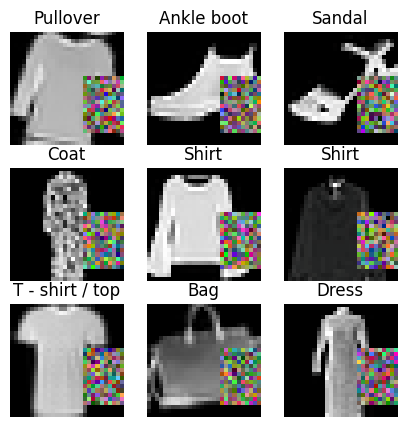

In [16]:
fashion_mnist_dls.show_batch(figsize=(5, 5))

Then we can create a `Learner` and fine-tune a model on our dataset like normal.

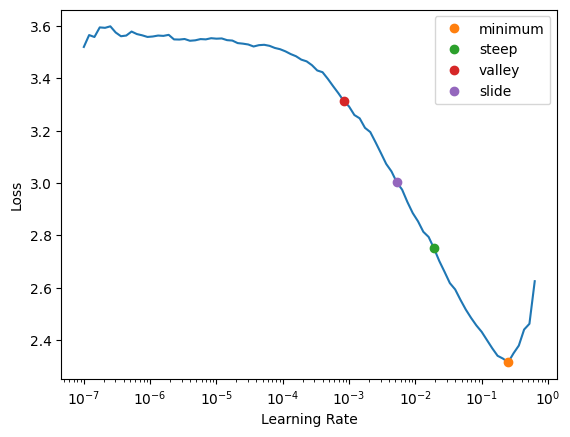

In [17]:
from fastai.vision.all import (
    vision_learner, resnet18, accuracy,
    minimum, steep, valley, slide
)

fashion_mnist_learn = vision_learner(fashion_mnist_dls, resnet18, metrics=accuracy)
lrs = fashion_mnist_learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

The graph seems to be steepest at the point marked `steep`, so we'll take that as our learning rate.

In [18]:
fashion_mnist_learn.fine_tune(3, lrs.steep)

epoch,train_loss,valid_loss,accuracy,time
0,1.324347,0.824672,0.700250,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.608801,0.476613,0.848417,00:12
1,0.468581,0.308588,0.882750,00:11
2,0.400869,0.285220,0.893000,00:11


Great!

# The Downside of the `DataBlock` API with a Hugging Face `Dataset`

Everything looks fine on the surface, but there's a hidden cost of using the `DataBlock` API with a Hugging Face `Dataset`: the time it takes to create the `DataLoaders`.
Let's re-run our `DataBlock` pipeline and time it.

In [19]:
import time

start_time = time.monotonic()

# Step 1
num_train, num_valid = len(fashion_mnist["train"]), len(fashion_mnist["test"])
valid_idxs = list(range(num_train, num_train + num_valid))

# Step 2
concat_fashion_mnist = concatenate_datasets([fashion_mnist["train"],
                                             fashion_mnist["test"]])

# Step 3
fashion_mnist_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=IndexSplitter(valid_idx=valid_idxs),
    item_tfms=[CropPad(32),
               RandomCrop(28)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats),
                Rotate(),
                RandomErasing()],
)

# instantiate the dataloaders
fashion_mnist_dls = fashion_mnist_dblock.dataloaders(concat_fashion_mnist, bs=512)

end_time = time.monotonic()
print("Time elapsed:", round(end_time - start_time, 1), "seconds")

Time elapsed: 18.9 seconds


That's too long for such a small dataset, and if we create a `DataBlock` with a bigger dataset like [Imagenette](https://github.com/fastai/imagenette), the time required to instantiate the `DataLoaders` will be even longer.
Let's first download the dataset...

In [20]:
imagenette = load_dataset("johnowhitaker/imagenette2-320")

::: {.column-margin}
Many thanks to [Jonathan Whitaker](https://huggingface.co/johnowhitaker) for uploading this version of Imagenette to the Hugging Face Hub!
:::

... then split the provided training set into a training and validation set...

In [21]:
imagenette = imagenette["train"].train_test_split(test_size=0.2)
imagenette

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10715
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2679
    })
})

... then set up some new functions to use in our `DataBlock`.

In [22]:
imagenette_label_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

imagenette_label_func = imagenette["train"].info.features["label"].int2str

def imagenette_get_y(item):
    label = imagenette_label_func(item["label"])
    return imagenette_label_dict[label]

::: {.column-margin}
The label dictionary was taken from [fastai's "Training Imagenette" tutorial](https://docs.fast.ai/tutorial.imagenette.html#loading-the-data-with-the-data-block-api).
:::

Now we'll run the exact same pre-processing steps, create a `DataBlock` and `DataLoaders`, time the whole process with `time.monotonic`, and keep track of memory usage the `%%memit` magic function.

In [23]:
%load_ext memory_profiler

In [24]:
from fastai.vision.all import Resize, aug_transforms

In [25]:
%%memit

start_time = time.monotonic()

# Step 1
num_train, num_valid = len(imagenette["train"]), len(imagenette["test"])
valid_idxs = list(range(num_train, num_train + num_valid))

# Step 2
concat_imagenette = concatenate_datasets([imagenette["train"],
                                          imagenette["test"]])

# Step 3
imagenette_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=imagenette_get_y,
    splitter=IndexSplitter(valid_idx=valid_idxs),
    item_tfms=[Resize(460)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats),
                *aug_transforms(size=224, min_scale=0.75),
                RandomErasing()],
)

# instantiate the dataloaders
imagenette_dls = imagenette_dblock.dataloaders(concat_imagenette, bs=64)

end_time = time.monotonic()
print("Time elapsed:", round(end_time - start_time, 1), "seconds")

Time elapsed: 35.6 seconds
peak memory: 22003.21 MiB, increment: 15222.07 MiB


That's a big memory increment!
It looks like we need a different approach to using Hugging Face image datasets with fastai.

# Image Paths

The [Hugging Face datasets documentation](https://huggingface.co/docs/datasets/image_load#local-files) indicates that, when loading a dataset that's stored locally, we can get back paths instead of decoded images by using `Dataset`'s `cast_column` method.
However, if you're downloading a dataset from the Hugging Face Hub, as we're doing in this post, you may get the images in a compressed format instead of as individual files, and this option won't work.

In [26]:
imagenette_with_paths = imagenette.cast_column("image", datasets.Image(decode=False))
list(imagenette_with_paths["train"][0]["image"].keys())

['bytes', 'path']

In [27]:
imagenette_with_paths["train"][0]["image"]["path"] is None

True

# The Mid-Level API

The mid-level API has the same problem as the `DataBlock` API.
Instantiating a fastai `Datasets` or `TfmdLists` object using Imagenette has the same problems as the `DataBlock` API, so we need to pass to fastai's low-level API.

# The Low-Level API

A faster way to use a Hugging Face image dataset with fastai is via the low-level API: `Pipeline`s of fastai `Transform`s and fastai's custom `DataLoader` class, which is compatible with PyTorch `DataLoader`s but has some additional fastai-flavored features.
We will also need to define some custom fastai-style transforms to handle our dataset format.
Let's start by working with Fashion-MNIST.

We'll start with some data conversion transforms.
Hugging Face datasets return indexed items as dictionaries...

In [28]:
sample_input = imagenette["train"][0]
sample_input

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x484>,
 'label': 7}

... while fastai transforms expect tuples, so we'll need a transform to convert formats.
Instead of writing a `__call__` method, fastai transforms need an `encodes` method.

In [29]:
from fastai.vision.all import Transform

class DictToTuple(Transform):
    order = -10 # do this before everything else
    split_idx = None # apply to both training and validation sets

    def encodes(self, x):
        return x["image"], x["label"]

::: {.column-margin}
We're relying on the fact that both of the datasets in this post use the column names `image` and `label`.
A more flexible design would pass the relevant column names at instantiation or automatically extract them from the dataset if possible.
:::

Let's make sure our transform does what we want it to do.

In [30]:
dict_to_tuple = DictToTuple()
tuple_input = dict_to_tuple(sample_input)
tuple_input

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x484>, 7)

::: {.column-margin}
Instead of calling the `encodes` method directly, we just use the instantiated `Transform` like a normal Python callable.
:::

Next, fastai's image transforms work best with its custom `PILImage` class, so we'll need another transform to convert our images to that format.

In [31]:
from PIL import Image
from fastai.vision.all import PILImage

class ConvertImage(Transform):
    order = -9 # do this after DictToTuple
    split_idx = None # apply to both training and validation sets

    def encodes(self, x: Image.Image):
        return PILImage.create(x)

When a fastai `Transform` is passed a tuple as input, fastcore's [type dispatch system](https://fastcore.fast.ai/dispatch.html#typedispatch) applies it to individual elements of the tuple that match the type annotation of the `encodes` method.
For example, `ConvertImage` will only be applied to `PIL.Image.Image` objects, and our target integer labels will be left alone.

In [32]:
convert_image = ConvertImage()
image_converted = convert_image(tuple_input)
image_converted

(PILImage mode=RGB size=320x484, 7)

Finally, we'll write a transform to convert the integer labels in our dataset to fastai `TensorCategory` labels, and we'll make sure they know how to decode and display themselves in figures later on by writing a `decodes` method.

In [34]:
from fastai.vision.all import TensorCategory

class ConvertCategory(Transform):
    order = -8 # do this after ConvertImage
    split_idx = None # apply to both the training and validation sets

    def __init__(self, label_func):
        self.label_func = label_func

    def encodes(self, x: int):
        return TensorCategory(x)

    def decodes(self, x: TensorCategory):
        return self.label_func(x)

As before, fastai's type dispatching ensures that this transform will only be applied to the integer labels and will leave the images alone.

In [35]:
def label2cat(x):
    decoded_label = imagenette_label_func(x.item())
    return imagenette_label_dict[decoded_label]

convert_category = ConvertCategory(label2cat)
category_converted = convert_category(image_converted)
category_converted

(PILImage mode=RGB size=320x484, TensorCategory(7))

The `decodes` method also uses type dispatching.

In [36]:
category_decoded = convert_category.decode(category_converted)
category_decoded

(PILImage mode=RGB size=320x484, 'gas pump')

::: {.column-margin}
Instead of calling the `decodes` method of the `Transform` directly, we call the `decode` method (without the `s`).
:::

I could not get fastai's `RandomErasing` to work with the low-level API, so we'll convert the implementation in [timm](https://github.com/huggingface/pytorch-image-models) to a fastai `Transform`.

In [37]:
# make sure not to override fastai's RandomErasing class
import timm.data.random_erasing as random_erasing

# fastai's ToTensor transform converts PILImages to fastai TensorImages
from fastai.vision.all import TensorImage

class RandomErase(Transform):
    order = 100 # do this after Normalize
    split_idx = 0 # apply only to the training set

    def __init__(self, p=0.5, mode='pixel', max_count=1):
        device = ('cuda' if torch.cuda.is_available()
                  else 'mps' if torch.backends.mps.is_available()
                  else 'cpu')
        self.tfm = random_erasing.RandomErasing(
            probability=p, mode=mode, device=device, max_count=max_count
        )

    def encodes(self, x: TensorImage):
        return self.tfm(x)

We'll always want some specific transforms in our data pre-processing, but we might want to experiment with including or excluding others.
To make that easier, we'll design our data pipelines to be easily extensible.
The transforms in a fastai `Pipeline` are automatically ordered by their `order` class attributes, which makes extensibility much easier to implement. 

In [38]:
from fastai.vision.all import ToTensor, IntToFloatTensor, Pipeline

def item_tfms_pipeline(split_idx, label_func, extra_tfms=None):
    tfms = [DictToTuple(),
            ConvertImage(),
            ConvertCategory(label_func),
            ToTensor()]
    if extra_tfms is not None:
        tfms.extend(extra_tfms)
    return Pipeline(tfms, split_idx=split_idx)

def batch_tfms_pipeline(split_idx, extra_tfms=None):
    tfms = [IntToFloatTensor()]
    if extra_tfms is not None:
        tfms.extend(extra_tfms)
    return Pipeline(tfms, split_idx=split_idx)

Now we can write some functions that generate a custom `DataLoaders`.

In [39]:
from fastai.vision.all import DataLoader, DataLoaders

def get_dl(ds, bs, shuffle, device, label_func, item_tfms=None, batch_tfms=None):
    return DataLoader(
        ds, bs=bs, shuffle=shuffle,
        after_item=item_tfms_pipeline(
            split_idx=int(not shuffle),
            label_func=label_func,
            extra_tfms=item_tfms
        ),
        after_batch=batch_tfms_pipeline(
            split_idx=int(not shuffle),
            extra_tfms=batch_tfms
        ),
        device=device,
        num_workers=8,
    )

def get_dls(ds_dict, bs, item_tfms, batch_tfms, label_dict=None):
    def label_func(x):
        result = ds_dict["train"].info.features["label"].int2str(x)
        if label_dict is not None:
            result = [label_dict[o] for o in result]
        return result

    device = ('cuda' if torch.cuda.is_available()
              else 'mps' if torch.backends.mps.is_available()
              else 'cpu')

    dls = DataLoaders(
        *[get_dl(ds_dict[k], bs=bs, shuffle=(k=="train"), device=device,
                 label_func=label_func, item_tfms=item_tfms, batch_tfms=batch_tfms)
          for k in ds_dict],
    )

    # need to set this or vision_learner complains
    dls.c = len(ds_dict["train"].info.features["label"].names)

    return dls

We've designed things so that the syntax is familiar to what we used with `DataBlock`s.

In [40]:
fashion_mnist_low_level_dls = get_dls(
    ds_dict=fashion_mnist,
    bs=512,
    item_tfms=[CropPad(32),
               RandomCrop(28)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats),
                Rotate(),
                RandomErase()]
)

Now let's train a model using our custom `DataLoaders` and compare with the `DataBlock` API.

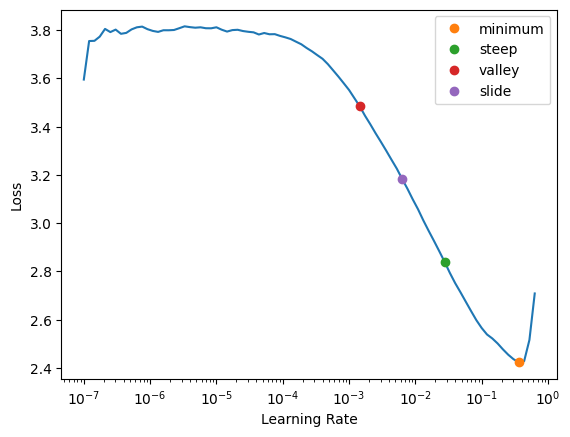

In [41]:
from fastai.vision.all import CrossEntropyLossFlat

fashion_mnist_low_level_learn = vision_learner(
    dls=fashion_mnist_low_level_dls,
    arch=resnet18,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy
)
lrs = fashion_mnist_low_level_learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

As usual, we'll use the learning rate given by the point marked `steep`.

In [42]:
fashion_mnist_low_level_learn.fine_tune(3, lrs.steep)

epoch,train_loss,valid_loss,accuracy,time
0,1.360952,0.741448,0.745417,00:20


epoch,train_loss,valid_loss,accuracy,time
0,0.596736,0.389657,0.862917,00:19
1,0.468772,0.316965,0.880583,00:16
2,0.383638,0.258381,0.902500,00:17


The training time per epoch is a little longer, but we still save time overall when we take into account the time needed to instantiate the `DataLoaders`.
Let's time the `DataLoaders` instantiation so we can compare the low-level API with the `DataBlock` API:

In [43]:
start_time = time.monotonic()

fashion_mnist_low_level_dls = get_dls(
    ds_dict=fashion_mnist,
    bs=512,
    item_tfms=[CropPad(32),
               RandomCrop(28)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats),
                Rotate(),
                RandomErase()]
)

end_time = time.monotonic()

print("Time elapsed:", round(end_time - start_time, 3), "seconds")

Time elapsed: 0.003 seconds


Much faster!

The fastai `DataLoader` class doesn't have a built-in `show_batch` method, but we can easily patch one in with fastcore's `@patch` decorator.
There is already a `show_batch` function in fastai, and `patch` takes advantage of the type dispatch system mentioned above to add `show_batch` as a method to the `DataLoaders` class.

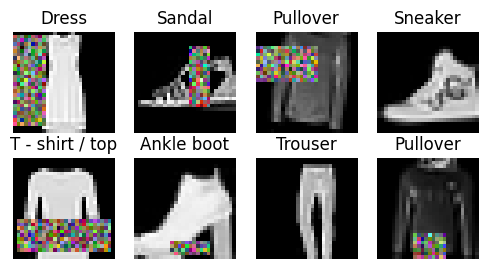

In [44]:
from operator import itemgetter
from fastcore.all import patch, mapt
from fastai.vision.all import show_images

@patch
def show_batch(self: DataLoaders, split='train', max_n=8, figsize=(6, 3)):
    batch = getattr(self, split).one_batch()
    slicer = itemgetter(slice(max_n))
    batch = mapt(slicer, batch)
    batch = getattr(self, split).after_batch.decode(batch)
    batch = getattr(self, split).after_item.decode(batch)
    images, labels = batch # unpacking for clarity
    show_images(images, nrows=2, figsize=figsize, titles=labels)

fashion_mnist_low_level_dls.show_batch()

::: {.column-margin}
A fastai `Pipeline` has its own `decode` method that calls the `decode` methods of the constituent transforms in the appropriate reversed order.
Each dataloader in a fastai `DataLoaders` has its own `after_item` and `after_batch` pipelines.
:::

Now let's see how long it takes to instantiate a `DataLoaders` and train a model on Imagenette with the low-level API.
We'll need an extra custom `Transform` to convert the grayscale images in Imagenette to RGB format.

In [45]:
class ConvertToRGB(Transform):
    order = 6 # after ToTensor
    split_idx = None # apply to both the training and validation sets

    def encodes(self, x: TensorImage):
        if x.shape[0] == 3:
            return x
        return x.repeat(3, 1, 1)

We'll also measure the memory usage when instantiating the `DataLoaders`.

In [46]:
%%memit

start_time = time.monotonic()

imagenette_low_level_dls = get_dls(
    ds_dict=imagenette,
    bs=64,
    item_tfms=[Resize(460), ConvertToRGB()],
    batch_tfms=[Normalize.from_stats(*imagenet_stats),
                *aug_transforms(size=224, min_scale=0.75),
                RandomErase()],
    label_dict=imagenette_label_dict
)

end_time = time.monotonic()
print("Elapsed time:", round(end_time - start_time, 3), "seconds")

Elapsed time: 0.006 seconds
peak memory: 22117.25 MiB, increment: 0.00 MiB


Much faster, and we're not using any additional memory!

We can also look at a batch of Imagenette images using our patched-in `show_batch` method for `DataLoaders`.

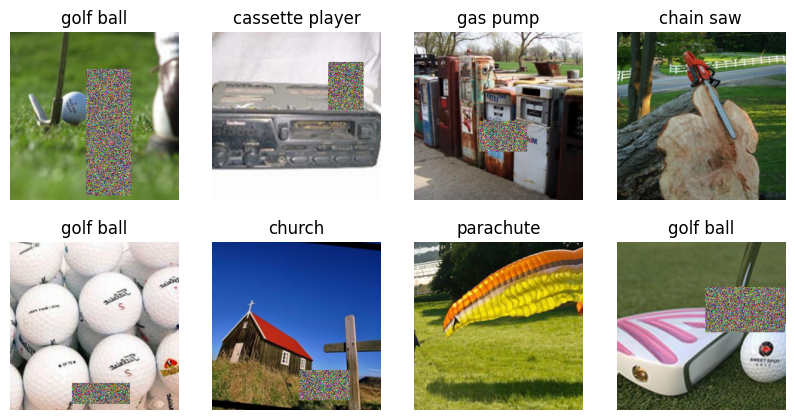

In [47]:
imagenette_low_level_dls.show_batch(figsize=(10, 5))

Now let's fine-tune a model.

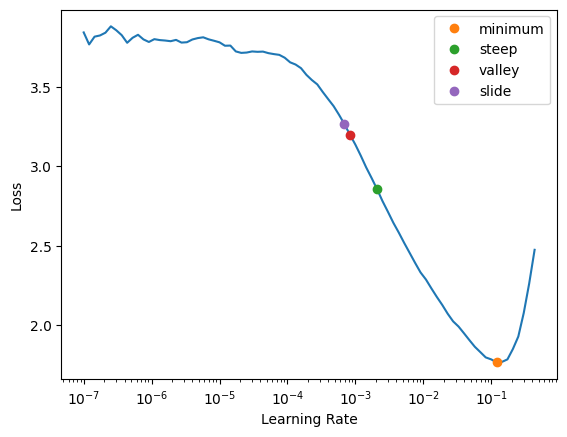

In [48]:
imagenette_low_level_learn = vision_learner(
    dls=imagenette_low_level_dls,
    arch=resnet18,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy
)
lrs = imagenette_low_level_learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

As usual, we'll take the point marked `steep` as our learning rate.

In [49]:
imagenette_low_level_learn.fine_tune(3, lrs.steep)

epoch,train_loss,valid_loss,accuracy,time
0,0.334781,0.070108,0.979097,00:23


epoch,train_loss,valid_loss,accuracy,time
0,0.197842,0.070056,0.980590,00:24
1,0.143560,0.058491,0.983949,00:23
2,0.101656,0.048196,0.986562,00:24


Just like with Fashion-MNIST, the training time per epoch for Imagenette is longer with the low-level API than with the `DataBlock` API.
However, we save so much time and memory usage when creating the `DataLoaders` with the low-level API that it wins by default.
Our data pipeline is also still quite flexible and extensible for working with Hugging Face datasets, so there's not much downside.